In [1]:
# Import necessary PyTorch libraries
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms


# Additional libraries for visualization and utilities
import matplotlib.pyplot as plt
import numpy as np
from unet_decoder import UNetDecoder

In [2]:
def get_device():
    """Selects the best available device for PyTorch computations.

    Returns:
        torch.device: The selected device.
    """

    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

device = get_device()
print(f"using device: {device}")

using device: cuda


In [3]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Normalize, ToTensor,Resize

transform = Compose([
    ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])


# Load the CelebA dataset
dataset = datasets.MNIST(root='./data', download=True, transform=transform)

# Splitting dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

print("Data loaders created for training and validation.")

Data loaders created for training and validation.


In [4]:
class ColdDiffusionModel(nn.Module):
    def __init__(self, input_shape, T=1000):
        super(ColdDiffusionModel, self).__init__()
        self.input_shape = input_shape
        self.T = T
        self.decoder = UNetDecoder(n_channels=input_shape[0])

        # Define the noise schedule
        self.alpha = self.create_noise_schedule(T)

    def create_noise_schedule(self, T):
        beta_start = 0.0001
        beta_end = 0.02
        betas = torch.linspace(beta_start, beta_end, T)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        return alphas_cumprod

    def forward(self, x):

        # Calculate the gaussian noise tensor
        batch_size = x.shape[0]
        epsilon = torch.randn(batch_size, 1, 28, 28).to(device)
        
        torch.cuda.empty_cache()

        #sample a timestep t
        t = np.random.randint(0, self.T)
        # Retrieve noise scheduler alpha_T
        alpha_t = self.alpha[t]

        # Calculate square root alphas
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)
        
        # Perform the weighted sum
        x_t = sqrt_alpha_t * x + sqrt_one_minus_alpha_t * epsilon

        torch.cuda.empty_cache()

        #Calculate the timestep tensor
        t = torch.tensor([t] * x_t.size(0), dtype=torch.long).to(x_t.device)

        # Perform the reconstruction process using Algorithm 2
        estimated_x = self.decoder(x_t,t)
        torch.cuda.empty_cache()
        return estimated_x

In [10]:
import os

def save_checkpoint(epoch, model, optimizer, filename="checkpoint.pth"):
    """Saves the model and optimizer state at the specified path."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, filename)
    print(f"Checkpoint saved at epoch {epoch} to {filename}")


def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    """Loads the model and optimizer state from the specified path."""
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Checkpoint loaded from {filename}, resuming training from epoch {epoch}")
        return epoch
    else:
        print(f"No checkpoint found at {filename}, starting from scratch.")
        return 0

In [11]:
import time  # Importing time to log the duration
from tqdm import tqdm


def validate(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient computation during validation
        for data, _ in val_loader:
            data = data.to(device)
            estimated_image = model(data)
            reconstruction_loss = nn.functional.mse_loss(data, estimated_image)
            total_val_loss += reconstruction_loss.item()  # Accumulate the validation loss
    
    avg_val_loss = total_val_loss / len(val_loader)  # Calculate average loss
    return avg_val_loss

def train(model, optimizer, train_loader, device, start_epoch, num_epochs):
    model.train()

    for epoch in range(start_epoch+1, num_epochs):
        epoch_loss = 0.0
        epoch_start_time = time.time()  # Time tracking for the epoch

        print(f"Starting epoch {epoch+1}/{num_epochs}")
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
            data = data.to(device)

            # Forward pass
            estimated_image = model(data)
            total_loss = nn.functional.mse_loss(data, estimated_image)

            # Backward pass
            if not torch.isnan(total_loss).any():
                total_loss.backward()
            else:
                print(f"Warning: NaN detected in total_loss at batch {batch_idx+1}, skipping backward pass.")

            optimizer.step()  # Only step the optimizer every `accumulation_steps`
            optimizer.zero_grad()  # Reset gradients only after accumulation

            # Safe-guarding against NaN for epoch_loss
            if not torch.isnan(total_loss).any():
                epoch_loss += total_loss.item()
            else:
                print(f"NaN detected, not adding to epoch_loss at batch {batch_idx+1}")

        # Save the model checkpoint
        save_checkpoint(epoch, model, optimizer, filename="mnist_cold_diffusion.pth")
        
        # Average loss after training for an epoch
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] completed in {time.time() - epoch_start_time:.2f} seconds, Avg Loss: {avg_loss}")

        # Validation phase
        avg_val_loss = validate(model, val_loader, device)
        print(f"Epoch [{epoch+1}/{num_epochs}] validation completed, Avg Validation Loss: {avg_val_loss}")

    return model


In [13]:
# Define the input shape
input_shape = (1, 28, 28)

# Create an instance of Gaussian Diffusion model
model = ColdDiffusionModel(input_shape).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

# Define the number of epochs and loss weights
num_epochs = 200

# Load the model training checkpoint
start_epoch = load_checkpoint(model, optimizer, filename="mnist_cold_diffusion.pth")
    
print(f"The training ended in epoch number: {start_epoch}")

# Train the model
trained_model = train(model, optimizer, train_loader, device, start_epoch, num_epochs)

Checkpoint loaded from mnist_cold_diffusion.pth, resuming training from epoch 99
The training ended in epoch number: 99
Starting epoch 101/200


Checkpoint saved at epoch 100 to mnist_cold_diffusion.pth
Epoch [101/200] completed in 25.89 seconds, Avg Loss: 0.38127547806253037
Epoch [101/200] validation completed, Avg Validation Loss: 1.022885059264112
Starting epoch 102/200


Checkpoint saved at epoch 101 to mnist_cold_diffusion.pth
Epoch [102/200] completed in 25.66 seconds, Avg Loss: 0.4453518375655015
Epoch [102/200] validation completed, Avg Validation Loss: 0.3062459119952264
Starting epoch 103/200


Checkpoint saved at epoch 102 to mnist_cold_diffusion.pth
Epoch [103/200] completed in 25.49 seconds, Avg Loss: 0.34966244335720936
Epoch [103/200] validation completed, Avg Validation Loss: 0.34607640472537976
Starting epoch 104/200


Checkpoint saved at epoch 103 to mnist_cold_diffusion.pth
Epoch [104/200] completed in 25.58 seconds, Avg Loss: 0.3451014501924316
Epoch [104/200] validation completed, Avg Validation Loss: 0.3185720673187616
Starting epoch 105/200


Checkpoint saved at epoch 104 to mnist_cold_diffusion.pth
Epoch [105/200] completed in 25.54 seconds, Avg Loss: 0.3264970570517083
Epoch [105/200] validation completed, Avg Validation Loss: 0.41660652774822043
Starting epoch 106/200


Checkpoint saved at epoch 105 to mnist_cold_diffusion.pth
Epoch [106/200] completed in 25.68 seconds, Avg Loss: 0.3724813518760105
Epoch [106/200] validation completed, Avg Validation Loss: 0.30295513950763864
Starting epoch 107/200


Checkpoint saved at epoch 106 to mnist_cold_diffusion.pth
Epoch [107/200] completed in 25.54 seconds, Avg Loss: 0.3349470314035813
Epoch [107/200] validation completed, Avg Validation Loss: 0.36185392739865535
Starting epoch 108/200


Checkpoint saved at epoch 107 to mnist_cold_diffusion.pth
Epoch [108/200] completed in 25.53 seconds, Avg Loss: 0.3215844156748305
Epoch [108/200] validation completed, Avg Validation Loss: 0.3191853377403335
Starting epoch 109/200


Checkpoint saved at epoch 108 to mnist_cold_diffusion.pth
Epoch [109/200] completed in 25.52 seconds, Avg Loss: 0.3333243210737904
Epoch [109/200] validation completed, Avg Validation Loss: 0.3945311729058108
Starting epoch 110/200


Checkpoint saved at epoch 109 to mnist_cold_diffusion.pth
Epoch [110/200] completed in 25.54 seconds, Avg Loss: 0.34574067829487226
Epoch [110/200] validation completed, Avg Validation Loss: 0.33265634634571667
Starting epoch 111/200


Checkpoint saved at epoch 110 to mnist_cold_diffusion.pth
Epoch [111/200] completed in 25.51 seconds, Avg Loss: 0.35638576875502864
Epoch [111/200] validation completed, Avg Validation Loss: 0.3734557049651135
Starting epoch 112/200


Checkpoint saved at epoch 111 to mnist_cold_diffusion.pth
Epoch [112/200] completed in 25.59 seconds, Avg Loss: 0.3132555407875528
Epoch [112/200] validation completed, Avg Validation Loss: 0.3266467633186542
Starting epoch 113/200


Checkpoint saved at epoch 112 to mnist_cold_diffusion.pth
Epoch [113/200] completed in 25.50 seconds, Avg Loss: 0.3364023855198175
Epoch [113/200] validation completed, Avg Validation Loss: 0.32743228209313957
Starting epoch 114/200


Checkpoint saved at epoch 113 to mnist_cold_diffusion.pth
Epoch [114/200] completed in 25.93 seconds, Avg Loss: 0.34998902757962547
Epoch [114/200] validation completed, Avg Validation Loss: 0.26996389204051663
Starting epoch 115/200


Checkpoint saved at epoch 114 to mnist_cold_diffusion.pth
Epoch [115/200] completed in 25.42 seconds, Avg Loss: 0.29847027829506745
Epoch [115/200] validation completed, Avg Validation Loss: 0.3221020742487955
Starting epoch 116/200


Checkpoint saved at epoch 115 to mnist_cold_diffusion.pth
Epoch [116/200] completed in 25.46 seconds, Avg Loss: 0.3359259956873332
Epoch [116/200] validation completed, Avg Validation Loss: 0.3060727085313819
Starting epoch 117/200


Checkpoint saved at epoch 116 to mnist_cold_diffusion.pth
Epoch [117/200] completed in 25.55 seconds, Avg Loss: 0.3609171916314711
Epoch [117/200] validation completed, Avg Validation Loss: 0.291132844650147
Starting epoch 118/200


Checkpoint saved at epoch 117 to mnist_cold_diffusion.pth
Epoch [118/200] completed in 25.53 seconds, Avg Loss: 0.3444120630205919
Epoch [118/200] validation completed, Avg Validation Loss: 0.3729416709269417
Starting epoch 119/200


Checkpoint saved at epoch 118 to mnist_cold_diffusion.pth
Epoch [119/200] completed in 25.47 seconds, Avg Loss: 0.33549347233430793
Epoch [119/200] validation completed, Avg Validation Loss: 0.32400310801669086
Starting epoch 120/200


Checkpoint saved at epoch 119 to mnist_cold_diffusion.pth
Epoch [120/200] completed in 25.57 seconds, Avg Loss: 0.3351363320136443
Epoch [120/200] validation completed, Avg Validation Loss: 0.29641328468433326
Starting epoch 121/200


Checkpoint saved at epoch 120 to mnist_cold_diffusion.pth
Epoch [121/200] completed in 25.42 seconds, Avg Loss: 0.326295148549291
Epoch [121/200] validation completed, Avg Validation Loss: 0.3121646115818913
Starting epoch 122/200


Checkpoint saved at epoch 121 to mnist_cold_diffusion.pth
Epoch [122/200] completed in 25.56 seconds, Avg Loss: 0.30859234867990015
Epoch [122/200] validation completed, Avg Validation Loss: 0.3328992585760561
Starting epoch 123/200


Checkpoint saved at epoch 122 to mnist_cold_diffusion.pth
Epoch [123/200] completed in 25.50 seconds, Avg Loss: 0.3443430504146963
Epoch [123/200] validation completed, Avg Validation Loss: 0.3059746464305716
Starting epoch 124/200


Checkpoint saved at epoch 123 to mnist_cold_diffusion.pth
Epoch [124/200] completed in 25.41 seconds, Avg Loss: 0.33503631517849863
Epoch [124/200] validation completed, Avg Validation Loss: 0.30382198253596954
Starting epoch 125/200


Checkpoint saved at epoch 124 to mnist_cold_diffusion.pth
Epoch [125/200] completed in 25.49 seconds, Avg Loss: 0.32709459092095494
Epoch [125/200] validation completed, Avg Validation Loss: 0.33970698142335054
Starting epoch 126/200


Checkpoint saved at epoch 125 to mnist_cold_diffusion.pth
Epoch [126/200] completed in 25.62 seconds, Avg Loss: 0.2920851055718958
Epoch [126/200] validation completed, Avg Validation Loss: 0.2904663610351371
Starting epoch 127/200


Checkpoint saved at epoch 126 to mnist_cold_diffusion.pth
Epoch [127/200] completed in 25.50 seconds, Avg Loss: 0.3696445774504294
Epoch [127/200] validation completed, Avg Validation Loss: 0.3398690763786633
Starting epoch 128/200


Checkpoint saved at epoch 127 to mnist_cold_diffusion.pth
Epoch [128/200] completed in 25.50 seconds, Avg Loss: 0.3415290801602726
Epoch [128/200] validation completed, Avg Validation Loss: 0.26800986305944263
Starting epoch 129/200


Checkpoint saved at epoch 128 to mnist_cold_diffusion.pth
Epoch [129/200] completed in 25.66 seconds, Avg Loss: 0.3057877631581699
Epoch [129/200] validation completed, Avg Validation Loss: 0.27568931161039606
Starting epoch 130/200


Checkpoint saved at epoch 129 to mnist_cold_diffusion.pth
Epoch [130/200] completed in 25.58 seconds, Avg Loss: 0.2982468457877015
Epoch [130/200] validation completed, Avg Validation Loss: 0.36330076978056436
Starting epoch 131/200


Checkpoint saved at epoch 130 to mnist_cold_diffusion.pth
Epoch [131/200] completed in 25.45 seconds, Avg Loss: 0.3303753151204437
Epoch [131/200] validation completed, Avg Validation Loss: 0.3144066592460459
Starting epoch 132/200


Checkpoint saved at epoch 131 to mnist_cold_diffusion.pth
Epoch [132/200] completed in 25.55 seconds, Avg Loss: 0.322175702109312
Epoch [132/200] validation completed, Avg Validation Loss: 0.314824325719878
Starting epoch 133/200


Checkpoint saved at epoch 132 to mnist_cold_diffusion.pth
Epoch [133/200] completed in 25.59 seconds, Avg Loss: 0.31468717514288924
Epoch [133/200] validation completed, Avg Validation Loss: 0.2832934742216318
Starting epoch 134/200


Checkpoint saved at epoch 133 to mnist_cold_diffusion.pth
Epoch [134/200] completed in 25.56 seconds, Avg Loss: 0.30198206948395817
Epoch [134/200] validation completed, Avg Validation Loss: 0.30696834310854565
Starting epoch 135/200


Checkpoint saved at epoch 134 to mnist_cold_diffusion.pth
Epoch [135/200] completed in 25.56 seconds, Avg Loss: 0.3102812750181183
Epoch [135/200] validation completed, Avg Validation Loss: 0.28559146445997535
Starting epoch 136/200


Checkpoint saved at epoch 135 to mnist_cold_diffusion.pth
Epoch [136/200] completed in 25.91 seconds, Avg Loss: 0.3281923112294947
Epoch [136/200] validation completed, Avg Validation Loss: 0.36140910093920264
Starting epoch 137/200


Checkpoint saved at epoch 136 to mnist_cold_diffusion.pth
Epoch [137/200] completed in 25.59 seconds, Avg Loss: 0.33040837517008187
Epoch [137/200] validation completed, Avg Validation Loss: 0.33944457080314294
Starting epoch 138/200


Checkpoint saved at epoch 137 to mnist_cold_diffusion.pth
Epoch [138/200] completed in 25.44 seconds, Avg Loss: 0.3271958309930439
Epoch [138/200] validation completed, Avg Validation Loss: 0.3409978265173119
Starting epoch 139/200


Checkpoint saved at epoch 138 to mnist_cold_diffusion.pth
Epoch [139/200] completed in 25.56 seconds, Avg Loss: 0.3208900042890261
Epoch [139/200] validation completed, Avg Validation Loss: 0.35124296124558896
Starting epoch 140/200


Checkpoint saved at epoch 139 to mnist_cold_diffusion.pth
Epoch [140/200] completed in 25.46 seconds, Avg Loss: 0.3249788463457177
Epoch [140/200] validation completed, Avg Validation Loss: 0.2660217655059743
Starting epoch 141/200


Checkpoint saved at epoch 140 to mnist_cold_diffusion.pth
Epoch [141/200] completed in 25.50 seconds, Avg Loss: 0.31852634172855565
Epoch [141/200] validation completed, Avg Validation Loss: 0.3160650034068509
Starting epoch 142/200


Checkpoint saved at epoch 141 to mnist_cold_diffusion.pth
Epoch [142/200] completed in 25.61 seconds, Avg Loss: 0.3252792515869563
Epoch [142/200] validation completed, Avg Validation Loss: 0.3342363555343485
Starting epoch 143/200


Checkpoint saved at epoch 142 to mnist_cold_diffusion.pth
Epoch [143/200] completed in 25.43 seconds, Avg Loss: 0.32036489985200267
Epoch [143/200] validation completed, Avg Validation Loss: 0.3512495693978556
Starting epoch 144/200


Checkpoint saved at epoch 143 to mnist_cold_diffusion.pth
Epoch [144/200] completed in 25.44 seconds, Avg Loss: 0.3567402015356347
Epoch [144/200] validation completed, Avg Validation Loss: 0.33836916079150237
Starting epoch 145/200


Checkpoint saved at epoch 144 to mnist_cold_diffusion.pth
Epoch [145/200] completed in 25.61 seconds, Avg Loss: 0.31681587789269783
Epoch [145/200] validation completed, Avg Validation Loss: 0.34218284885270245
Starting epoch 146/200


Checkpoint saved at epoch 145 to mnist_cold_diffusion.pth
Epoch [146/200] completed in 25.52 seconds, Avg Loss: 0.3321762028041606
Epoch [146/200] validation completed, Avg Validation Loss: 0.37136769838670786
Starting epoch 147/200


Checkpoint saved at epoch 146 to mnist_cold_diffusion.pth
Epoch [147/200] completed in 25.97 seconds, Avg Loss: 0.3049432944053163
Epoch [147/200] validation completed, Avg Validation Loss: 0.32136809624275786
Starting epoch 148/200


Checkpoint saved at epoch 147 to mnist_cold_diffusion.pth
Epoch [148/200] completed in 25.53 seconds, Avg Loss: 0.31384366469830277
Epoch [148/200] validation completed, Avg Validation Loss: 0.3294440553810923
Starting epoch 149/200


Checkpoint saved at epoch 148 to mnist_cold_diffusion.pth
Epoch [149/200] completed in 25.57 seconds, Avg Loss: 0.3205084925135598
Epoch [149/200] validation completed, Avg Validation Loss: 0.28973000474952837
Starting epoch 150/200


Checkpoint saved at epoch 149 to mnist_cold_diffusion.pth
Epoch [150/200] completed in 25.47 seconds, Avg Loss: 0.311624536880292
Epoch [150/200] validation completed, Avg Validation Loss: 0.3079795772358379
Starting epoch 151/200


Checkpoint saved at epoch 150 to mnist_cold_diffusion.pth
Epoch [151/200] completed in 25.56 seconds, Avg Loss: 0.32621054698651036
Epoch [151/200] validation completed, Avg Validation Loss: 0.29830699516187836
Starting epoch 152/200


Checkpoint saved at epoch 151 to mnist_cold_diffusion.pth
Epoch [152/200] completed in 25.47 seconds, Avg Loss: 0.3211151591722543
Epoch [152/200] validation completed, Avg Validation Loss: 0.319572611469181
Starting epoch 153/200


Checkpoint saved at epoch 152 to mnist_cold_diffusion.pth
Epoch [153/200] completed in 25.55 seconds, Avg Loss: 0.34907797660523404
Epoch [153/200] validation completed, Avg Validation Loss: 0.3367841558585419
Starting epoch 154/200


Checkpoint saved at epoch 153 to mnist_cold_diffusion.pth
Epoch [154/200] completed in 25.60 seconds, Avg Loss: 0.3413228704960396
Epoch [154/200] validation completed, Avg Validation Loss: 0.3352931302902784
Starting epoch 155/200


Checkpoint saved at epoch 154 to mnist_cold_diffusion.pth
Epoch [155/200] completed in 25.87 seconds, Avg Loss: 0.3187861554538831
Epoch [155/200] validation completed, Avg Validation Loss: 0.3270253740929741
Starting epoch 156/200


Checkpoint saved at epoch 155 to mnist_cold_diffusion.pth
Epoch [156/200] completed in 25.42 seconds, Avg Loss: 0.33522252353218696
Epoch [156/200] validation completed, Avg Validation Loss: 0.3178084969887153
Starting epoch 157/200


Checkpoint saved at epoch 156 to mnist_cold_diffusion.pth
Epoch [157/200] completed in 25.60 seconds, Avg Loss: 0.30315028096642344
Epoch [157/200] validation completed, Avg Validation Loss: 0.3107010502903227
Starting epoch 158/200


Checkpoint saved at epoch 157 to mnist_cold_diffusion.pth
Epoch [158/200] completed in 26.00 seconds, Avg Loss: 0.3170360934541871
Epoch [158/200] validation completed, Avg Validation Loss: 0.3215224762135086
Starting epoch 159/200


Checkpoint saved at epoch 158 to mnist_cold_diffusion.pth
Epoch [159/200] completed in 25.57 seconds, Avg Loss: 0.32070086867765835
Epoch [159/200] validation completed, Avg Validation Loss: 0.30020793071239593
Starting epoch 160/200


Checkpoint saved at epoch 159 to mnist_cold_diffusion.pth
Epoch [160/200] completed in 25.47 seconds, Avg Loss: 0.3212424330078065
Epoch [160/200] validation completed, Avg Validation Loss: 0.2985487824660092
Starting epoch 161/200


Checkpoint saved at epoch 160 to mnist_cold_diffusion.pth
Epoch [161/200] completed in 25.44 seconds, Avg Loss: 0.31398979493913554
Epoch [161/200] validation completed, Avg Validation Loss: 0.30350515363549696
Starting epoch 162/200


Checkpoint saved at epoch 161 to mnist_cold_diffusion.pth
Epoch [162/200] completed in 25.39 seconds, Avg Loss: 0.3148463609820853
Epoch [162/200] validation completed, Avg Validation Loss: 0.3607162503981368
Starting epoch 163/200


Checkpoint saved at epoch 162 to mnist_cold_diffusion.pth
Epoch [163/200] completed in 25.45 seconds, Avg Loss: 0.304610058211411
Epoch [163/200] validation completed, Avg Validation Loss: 0.2994887720337732
Starting epoch 164/200


Checkpoint saved at epoch 163 to mnist_cold_diffusion.pth
Epoch [164/200] completed in 25.44 seconds, Avg Loss: 0.31239911695880196
Epoch [164/200] validation completed, Avg Validation Loss: 0.3155762235376429
Starting epoch 165/200


Checkpoint saved at epoch 164 to mnist_cold_diffusion.pth
Epoch [165/200] completed in 25.57 seconds, Avg Loss: 0.3114406257271767
Epoch [165/200] validation completed, Avg Validation Loss: 0.32587470014039627
Starting epoch 166/200


Checkpoint saved at epoch 165 to mnist_cold_diffusion.pth
Epoch [166/200] completed in 25.59 seconds, Avg Loss: 0.34403302836511285
Epoch [166/200] validation completed, Avg Validation Loss: 0.36325437771627045
Starting epoch 167/200


Checkpoint saved at epoch 166 to mnist_cold_diffusion.pth
Epoch [167/200] completed in 25.76 seconds, Avg Loss: 0.3065798701858148
Epoch [167/200] validation completed, Avg Validation Loss: 0.33081310729005753
Starting epoch 168/200


Checkpoint saved at epoch 167 to mnist_cold_diffusion.pth
Epoch [168/200] completed in 25.58 seconds, Avg Loss: 0.3176972812693566
Epoch [168/200] validation completed, Avg Validation Loss: 0.333117724787642
Starting epoch 169/200


Checkpoint saved at epoch 168 to mnist_cold_diffusion.pth
Epoch [169/200] completed in 25.46 seconds, Avg Loss: 0.31052917943832775
Epoch [169/200] validation completed, Avg Validation Loss: 0.2695536525484095
Starting epoch 170/200


Checkpoint saved at epoch 169 to mnist_cold_diffusion.pth
Epoch [170/200] completed in 25.84 seconds, Avg Loss: 0.3306000826486076
Epoch [170/200] validation completed, Avg Validation Loss: 0.294722187459132
Starting epoch 171/200


Checkpoint saved at epoch 170 to mnist_cold_diffusion.pth
Epoch [171/200] completed in 25.55 seconds, Avg Loss: 0.32831929094499596
Epoch [171/200] validation completed, Avg Validation Loss: 0.3020566897144779
Starting epoch 172/200


Checkpoint saved at epoch 171 to mnist_cold_diffusion.pth
Epoch [172/200] completed in 25.50 seconds, Avg Loss: 0.3420743040830518
Epoch [172/200] validation completed, Avg Validation Loss: 0.24205681449297736
Starting epoch 173/200


Checkpoint saved at epoch 172 to mnist_cold_diffusion.pth
Epoch [173/200] completed in 25.45 seconds, Avg Loss: 0.3352356014158577
Epoch [173/200] validation completed, Avg Validation Loss: 0.3174222428921333
Starting epoch 174/200


Checkpoint saved at epoch 173 to mnist_cold_diffusion.pth
Epoch [174/200] completed in 25.56 seconds, Avg Loss: 0.31674196155089884
Epoch [174/200] validation completed, Avg Validation Loss: 0.3440371444064906
Starting epoch 175/200


Checkpoint saved at epoch 174 to mnist_cold_diffusion.pth
Epoch [175/200] completed in 25.49 seconds, Avg Loss: 0.31694239405325303
Epoch [175/200] validation completed, Avg Validation Loss: 0.3111980106716262
Starting epoch 176/200


Checkpoint saved at epoch 175 to mnist_cold_diffusion.pth
Epoch [176/200] completed in 25.85 seconds, Avg Loss: 0.31296742728973426
Epoch [176/200] validation completed, Avg Validation Loss: 0.3200046423465965
Starting epoch 177/200


Checkpoint saved at epoch 176 to mnist_cold_diffusion.pth
Epoch [177/200] completed in 25.49 seconds, Avg Loss: 0.3481225318835738
Epoch [177/200] validation completed, Avg Validation Loss: 0.3426961433030962
Starting epoch 178/200


Checkpoint saved at epoch 177 to mnist_cold_diffusion.pth
Epoch [178/200] completed in 25.58 seconds, Avg Loss: 0.3087785370048756
Epoch [178/200] validation completed, Avg Validation Loss: 0.32255170635874086
Starting epoch 179/200


Checkpoint saved at epoch 178 to mnist_cold_diffusion.pth
Epoch [179/200] completed in 25.53 seconds, Avg Loss: 0.3208583048569659
Epoch [179/200] validation completed, Avg Validation Loss: 0.30548093292460915
Starting epoch 180/200


Checkpoint saved at epoch 179 to mnist_cold_diffusion.pth
Epoch [180/200] completed in 25.55 seconds, Avg Loss: 0.31931982039194556
Epoch [180/200] validation completed, Avg Validation Loss: 0.33360945064069186
Starting epoch 181/200


Checkpoint saved at epoch 180 to mnist_cold_diffusion.pth
Epoch [181/200] completed in 25.51 seconds, Avg Loss: 0.3079888236358141
Epoch [181/200] validation completed, Avg Validation Loss: 0.314213157349707
Starting epoch 182/200


Checkpoint saved at epoch 181 to mnist_cold_diffusion.pth
Epoch [182/200] completed in 25.96 seconds, Avg Loss: 0.32012339146248997
Epoch [182/200] validation completed, Avg Validation Loss: 0.31541456082560854
Starting epoch 183/200


Checkpoint saved at epoch 182 to mnist_cold_diffusion.pth
Epoch [183/200] completed in 25.56 seconds, Avg Loss: 0.2968942320671243
Epoch [183/200] validation completed, Avg Validation Loss: 0.3776134893148295
Starting epoch 184/200


Checkpoint saved at epoch 183 to mnist_cold_diffusion.pth
Epoch [184/200] completed in 25.50 seconds, Avg Loss: 0.3198867518805588
Epoch [184/200] validation completed, Avg Validation Loss: 0.34192982743781536
Starting epoch 185/200


Checkpoint saved at epoch 184 to mnist_cold_diffusion.pth
Epoch [185/200] completed in 25.50 seconds, Avg Loss: 0.3140222840808953
Epoch [185/200] validation completed, Avg Validation Loss: 0.36973588608646213
Starting epoch 186/200


Checkpoint saved at epoch 185 to mnist_cold_diffusion.pth
Epoch [186/200] completed in 25.53 seconds, Avg Loss: 0.32694176079984755
Epoch [186/200] validation completed, Avg Validation Loss: 0.33687322359145716
Starting epoch 187/200


Checkpoint saved at epoch 186 to mnist_cold_diffusion.pth
Epoch [187/200] completed in 25.60 seconds, Avg Loss: 0.29875397534885756
Epoch [187/200] validation completed, Avg Validation Loss: 0.34819869540057125
Starting epoch 188/200


Checkpoint saved at epoch 187 to mnist_cold_diffusion.pth
Epoch [188/200] completed in 25.48 seconds, Avg Loss: 0.348105351055041
Epoch [188/200] validation completed, Avg Validation Loss: 0.39066301973442485
Starting epoch 189/200


Checkpoint saved at epoch 188 to mnist_cold_diffusion.pth
Epoch [189/200] completed in 25.58 seconds, Avg Loss: 0.3109367872911195
Epoch [189/200] validation completed, Avg Validation Loss: 0.2925400418932847
Starting epoch 190/200


Checkpoint saved at epoch 189 to mnist_cold_diffusion.pth
Epoch [190/200] completed in 25.30 seconds, Avg Loss: 0.34192040949718405
Epoch [190/200] validation completed, Avg Validation Loss: 0.31931232074597615
Starting epoch 191/200


Checkpoint saved at epoch 190 to mnist_cold_diffusion.pth
Epoch [191/200] completed in 25.43 seconds, Avg Loss: 0.31514123251195997
Epoch [191/200] validation completed, Avg Validation Loss: 0.3362422061420264
Starting epoch 192/200


Checkpoint saved at epoch 191 to mnist_cold_diffusion.pth
Epoch [192/200] completed in 25.91 seconds, Avg Loss: 0.3193440379120099
Epoch [192/200] validation completed, Avg Validation Loss: 0.32154050739630663
Starting epoch 193/200


Checkpoint saved at epoch 192 to mnist_cold_diffusion.pth
Epoch [193/200] completed in 25.59 seconds, Avg Loss: 0.3411555323731154
Epoch [193/200] validation completed, Avg Validation Loss: 0.34765155789469604
Starting epoch 194/200


Checkpoint saved at epoch 193 to mnist_cold_diffusion.pth
Epoch [194/200] completed in 25.45 seconds, Avg Loss: 0.33496049103854847
Epoch [194/200] validation completed, Avg Validation Loss: 0.34755028415585254
Starting epoch 195/200


Checkpoint saved at epoch 194 to mnist_cold_diffusion.pth
Epoch [195/200] completed in 25.51 seconds, Avg Loss: 0.28769586807473874
Epoch [195/200] validation completed, Avg Validation Loss: 0.2914719185129333
Starting epoch 196/200


Checkpoint saved at epoch 195 to mnist_cold_diffusion.pth
Epoch [196/200] completed in 25.51 seconds, Avg Loss: 0.313228013294749
Epoch [196/200] validation completed, Avg Validation Loss: 0.3002955214222001
Starting epoch 197/200


Checkpoint saved at epoch 196 to mnist_cold_diffusion.pth
Epoch [197/200] completed in 25.48 seconds, Avg Loss: 0.32081568087885776
Epoch [197/200] validation completed, Avg Validation Loss: 0.33575985568298145
Starting epoch 198/200


Checkpoint saved at epoch 197 to mnist_cold_diffusion.pth
Epoch [198/200] completed in 26.11 seconds, Avg Loss: 0.29419479523971676
Epoch [198/200] validation completed, Avg Validation Loss: 0.3550366778502568
Starting epoch 199/200


Checkpoint saved at epoch 198 to mnist_cold_diffusion.pth
Epoch [199/200] completed in 25.49 seconds, Avg Loss: 0.31644791869074107
Epoch [199/200] validation completed, Avg Validation Loss: 0.37087244758917454
Starting epoch 200/200


Checkpoint saved at epoch 199 to mnist_cold_diffusion.pth
Epoch [200/200] completed in 25.49 seconds, Avg Loss: 0.30702317525974165
Epoch [200/200] validation completed, Avg Validation Loss: 0.3591706953543991


In [15]:
# Define the input shape
input_shape = (1, 28, 28)

# Example usage
model = ColdDiffusionModel(input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

start_epoch = load_checkpoint(model, optimizer, filename="mnist_cold_diffusion.pth")
print(f"The training ended in epoch number: {start_epoch}")

Checkpoint loaded from mnist_cold_diffusion.pth, resuming training from epoch 199
The training ended in epoch number: 199


## Sampling according to Algorithm 1

In [23]:
import torch
import torch.nn.functional as F

# Define the necessary parameters and variables
T = 1000
beta_start = 0.0001
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1 - beta
alpha = torch.cumprod(alphas, dim=0)

model.eval()

sampled_data = {}
batch_size = 128


with torch.no_grad():
    for batch_idx in range(32):
        x = torch.randn(batch_size, 1, 28, 28).to(device)
        for s in range(T-1, 0, -1):
            t = torch.tensor([s] * x.size(0), dtype=torch.long).to(device)
            x_hat = model.decoder(x, t)
            z_hat = (1.0/torch.sqrt(1-alpha[s]))* (x - torch.sqrt(alpha[s]) * x_hat) 
            x = torch.sqrt(alpha[s-1]) * x_hat + torch.sqrt(1-alpha[s-1]) * z_hat
            
        # Reverse normalization
        x = x * 0.3081 + 0.1307
        x = (x.clamp(0, 1) * 255).type(torch.uint8)
            
        # Store the sampled images
        for i in range(x.size(0)):
            sampled_data[batch_idx * batch_size + i] = {
                'sampled': x[i].cpu()
            }

In [27]:

# Save the dictionary to a .pt file
torch.save(sampled_data, 'mnist_cold_alg1.pt')

print("Sampled data saved to 'mnist_cold_alg1.pt'")


Sampled data saved to 'mnist_cold_alg1.pt'


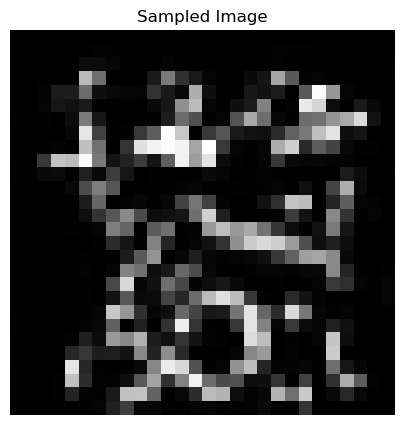

In [29]:
import torch
import matplotlib.pyplot as plt

# Load the saved data
sampled_data = torch.load('mnist_cold_alg1.pt')

# Access a specific entry
index = 50 # Replace with the index you want to check
sampled_image = sampled_data[index]['sampled']


# Convert the tensor to a numpy array
sampled_image = sampled_image.cpu().numpy().transpose(1, 2, 0)


# Display the sampled image
plt.figure(figsize=(5, 5))
plt.imshow(sampled_image, cmap = 'gray')
plt.title("Sampled Image")
plt.axis('off')
plt.show()


In [31]:
print(len(sampled_data))

4096


## Sampling according to Algorithm 2

In [ ]:
import torch
import torch.nn.functional as F

# Define the necessary parameters and variables
T = 1000
beta_start = 0.0001
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1 - beta
alpha = torch.cumprod(alphas, dim=0)

model.eval()

sampled_data = {}
batch_size = 128


with torch.no_grad():
    for batch_idx in range(32):
        x = torch.randn(batch_size, 1, 28, 28).to(device)
        for s in range(T-1, 0, -1):
            t = torch.tensor([s] * x.size(0), dtype=torch.long).to(device)
            x_hat = model.decoder(x, t)
            z_hat = (1.0/torch.sqrt(1-alpha[s]))* (x - torch.sqrt(alpha[s]) * x_hat)
            D_s_minus_one = torch.sqrt(alpha[s-1]) * x_hat + torch.sqrt(1-alpha[s-1]) * z_hat
            D_s = torch.sqrt(alpha[s]) * x_hat + torch.sqrt(1-alpha[s]) * z_hat
            x = x - D_s + D_s_minus_one
            
        # Reverse normalization
        x = x * 0.3081 + 0.1307
        x = (x.clamp(0, 1) * 255).type(torch.uint8)
            
        # Store the sampled images
        for i in range(x.size(0)):
            sampled_data[batch_idx * batch_size + i] = {
                'sampled': x[i].cpu()
            }

In [ ]:

# Save the dictionary to a .pt file
torch.save(sampled_data, 'mnist_cold_alg2.pt')

print("Sampled data saved to 'mnist_cold_alg2.pt'")

In [ ]:
import torch
import matplotlib.pyplot as plt

# Load the saved data
sampled_data = torch.load('mnist_cold_alg2.pt')

# Access a specific entry
index = 50 # Replace with the index you want to check
sampled_image = sampled_data[index]['sampled']


# Convert the tensor to a numpy array
sampled_image = sampled_image.cpu().numpy().transpose(1, 2, 0)


# Display the sampled image
plt.figure(figsize=(5, 5))
plt.imshow(sampled_image, cmap = 'gray')
plt.title("Sampled Image")
plt.axis('off')
plt.show()
